# DBSCAN Applied to Dissected Data, using Burst View

This notebook is a test to check if the RF feature selection was effective: we are bruteforcing the 44 features (dissected data, to which we applied the processing in `models_feature_engineering/feature_statistics_dissected.ipynb`) to find the ones that maximize the clustering metrics (homogeneity and completeness).

## Libraries and Configurations

Import configuration files

In [1]:
from configparser import ConfigParser

config = ConfigParser()
config.read("../config.ini")

['../config.ini']

Import **data libraries**

In [2]:
import pandas as pd

Import **other libraries**

In [3]:
from rich.progress import Progress
from rich import traceback

traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x769f0277fe10>>

Custom helper scripts

In [4]:
%cd ..
from scripts import plotHelper, encodingHelper
%cd data_exploration_cleaning

/home/bacci/COMPACT/notebooks


/home/bacci/COMPACT/notebooks/data_exploration_cleaning


## Import Data

In [5]:
burst_csv = config["DEFAULT"]["interim_path"] + "dissected/std_burst_dissected_df.csv"

In [6]:
burst_df = pd.read_csv(burst_csv, index_col=0)

In [7]:
burst_df

,MAC Address,Channel,DS Channel,Vendor Specific Tags,Length,Label,Supported Rates 1,Supported Rates 2,Supported Rates 3,Supported Rates 4,...,TIM_Broadcast,BSS_Transition,Multiple_BSSID,Timing_Measurement,SSID_List,DMS,Interworking,QoS_Map,WNM_Notification,Operating_Mode_Notification
0,00:0f:00:6a:68:8b,1,NaN,2,279,SamsungJ6_K,65.0,66.0,69.5,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02:00:00:00:00:00,11,9.0,11,123,SamsungM31_A,1.0,2.0,5.5,11.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,02:00:00:00:3e:b2,11,11.0,62,132,iPhone11_C,65.0,66.0,69.5,75.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,02:00:3a:5e:a1:f4,11,10.0,62,132,iPhone11_B,65.0,66.0,69.5,75.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,02:02:70:30:b6:43,1,3.0,62,143,iPhone12_W,65.0,66.0,69.5,75.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,fe:f9:ac:47:0d:b7,11,11.0,62,131,iPhone12_W,65.0,66.0,69.5,75.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4411,fe:f9:fc:fb:83:9e,6,1.0,1,156,iPhone6_N,1.0,2.0,5.5,11.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4412,fe:fc:07:34:10:69,1,1.0,62,132,iPhone11_C,65.0,66.0,69.5,75.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4413,fe:fc:aa:d1:89:d1,1,2.0,62,143,iPhone12_W,65.0,66.0,69.5,75.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Normalize Data

Let's fill all the `NaN` with `-1`, since it is not a value that should appear

In [8]:
burst_df.fillna("-1", inplace=True)

/tmp/ipykernel_14824/1153771547.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  burst_df.fillna("-1", inplace=True)


First of all, we need to convert numeric column types from `object` to numeric, like `float64`. Basically all the columns can be converted, except from `MAC Address` and `Label`.

In [9]:
# Assuming df is your DataFrame
numeric_columns = [
    col for col in burst_df.columns if col not in ["MAC Address", "Label"]
]

# Convert selected columns to numeric type
burst_df[numeric_columns] = burst_df[numeric_columns].apply(
    pd.to_numeric, errors="coerce"
)

Now we can apply min-max normalization

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
# Normalize each column using Min-Max scaling
scaler = MinMaxScaler()
burst_df[numeric_columns] = scaler.fit_transform(burst_df[numeric_columns])

Let's check how the data is looking

In [12]:
burst_df

,MAC Address,Channel,DS Channel,Vendor Specific Tags,Length,Label,Supported Rates 1,Supported Rates 2,Supported Rates 3,Supported Rates 4,...,TIM_Broadcast,BSS_Transition,Multiple_BSSID,Timing_Measurement,SSID_List,DMS,Interworking,QoS_Map,WNM_Notification,Operating_Mode_Notification
0,00:0f:00:6a:68:8b,0.0,0.000000,0.032258,1.000000,SamsungJ6_K,1.0,1.0,1.0,1.0,...,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,02:00:00:00:00:00,1.0,0.714286,0.177419,0.287671,SamsungM31_A,0.0,0.0,0.0,0.0,...,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0
3,02:00:00:00:3e:b2,1.0,0.857143,1.000000,0.328767,iPhone11_C,1.0,1.0,1.0,1.0,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
4,02:00:3a:5e:a1:f4,1.0,0.785714,1.000000,0.328767,iPhone11_B,1.0,1.0,1.0,1.0,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
5,02:02:70:30:b6:43,0.0,0.285714,1.000000,0.378995,iPhone12_W,1.0,1.0,1.0,1.0,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,fe:f9:ac:47:0d:b7,1.0,0.857143,1.000000,0.324201,iPhone12_W,1.0,1.0,1.0,1.0,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
4411,fe:f9:fc:fb:83:9e,0.5,0.142857,0.016129,0.438356,iPhone6_N,0.0,0.0,0.0,0.0,...,1.0,1.0,0.5,0.5,0.5,1.0,1.0,0.5,0.5,1.0
4412,fe:fc:07:34:10:69,0.0,0.142857,1.000000,0.328767,iPhone11_C,1.0,1.0,1.0,1.0,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
4413,fe:fc:aa:d1:89:d1,0.0,0.214286,1.000000,0.378995,iPhone12_W,1.0,1.0,1.0,1.0,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0


In [13]:
column_std = burst_df.drop(columns=["MAC Address", "Label"]).std()
print(column_std)

Channel                                                0.408516
DS Channel                                             0.296459
Vendor Specific Tags                                   0.309728
Length                                                 0.120505
Supported Rates 1                                      0.490156
Supported Rates 2                                      0.490156
Supported Rates 3                                      0.490156
Supported Rates 4                                      0.490156
Extended Supported Rates 1                             0.322036
Extended Supported Rates 2                             0.322031
Extended Supported Rates 3                             0.322048
Extended Supported Rates 4                             0.322212
Forty_Mhz_Intolerant                                   0.356372
DSSS_CCK                                               0.175619
Max_A_MSDU                                             0.167987
Rx_STBC                                 

## Splitting Columns

In [14]:
X = burst_df.drop(columns=["MAC Address", "Label"])
y = burst_df["Label"]

## Hyperparameter Tuning

In [15]:
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV

We are using `GridSearchCV` to perform exhaustive search over specified parameter values for an estimator. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

Let's define the parameter grid. In the case of DBSCAN we have 2 parameters: `eps` and `min_samples`

In [16]:
param_grid = {
    "eps": [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
    "min_samples": [3, 5, 10, 20, 30],
}

Performing grid search 

In [17]:
dbscan = DBSCAN()

In [20]:
from sklearn.metrics import silhouette_score


# Define the scoring function
def silhouette_scorer(estimator, X):
    labels = estimator.labels_
    return silhouette_score(X, labels)


# Create the GridSearchCV object with the scoring function
grid_search = GridSearchCV(dbscan, param_grid, scoring=silhouette_scorer)
grid_search.fit(X, y)

/home/bacci/COMPACT/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:988: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/bacci/COMPACT/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 977, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: silhouette_scorer() takes 2 positional arguments but 3 were given

  warnings.warn(
/home/bacci/COMPACT/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:988: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/bacci/COMPACT/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 977, in _score
    scores = scorer(estim

GridSearchCV(estimator=DBSCAN(),
             param_grid={'eps': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
                         'min_samples': [3, 5, 10, 20, 30]},
             scoring=<function silhouette_scorer at 0x769eb69ad440>)

Printing best parameters

In [21]:
best_eps = grid_search.best_params_["eps"]
best_min_samples = grid_search.best_params_["min_samples"]

In [22]:
print("Best eps:", best_eps)
print("Best min_samples:", best_min_samples)

Best eps: 0.01
Best min_samples: 3


## Clustering using best parameters

Using DBSCAN algorithm to perform clustering

In [23]:
clusterer = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(
    burst_df.drop(columns=["MAC Address", "Label"])
)

In [24]:
burst_df["Cluster"] = clusterer.labels_

In [25]:
burst_df

,MAC Address,Channel,DS Channel,Vendor Specific Tags,Length,Label,Supported Rates 1,Supported Rates 2,Supported Rates 3,Supported Rates 4,...,BSS_Transition,Multiple_BSSID,Timing_Measurement,SSID_List,DMS,Interworking,QoS_Map,WNM_Notification,Operating_Mode_Notification,Cluster
0,00:0f:00:6a:68:8b,0.0,0.000000,0.032258,1.000000,SamsungJ6_K,1.0,1.0,1.0,1.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,-1
2,02:00:00:00:00:00,1.0,0.714286,0.177419,0.287671,SamsungM31_A,0.0,0.0,0.0,0.0,...,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,-1
3,02:00:00:00:3e:b2,1.0,0.857143,1.000000,0.328767,iPhone11_C,1.0,1.0,1.0,1.0,...,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0,0
4,02:00:3a:5e:a1:f4,1.0,0.785714,1.000000,0.328767,iPhone11_B,1.0,1.0,1.0,1.0,...,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0,1
5,02:02:70:30:b6:43,0.0,0.285714,1.000000,0.378995,iPhone12_W,1.0,1.0,1.0,1.0,...,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,fe:f9:ac:47:0d:b7,1.0,0.857143,1.000000,0.324201,iPhone12_W,1.0,1.0,1.0,1.0,...,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0,0
4411,fe:f9:fc:fb:83:9e,0.5,0.142857,0.016129,0.438356,iPhone6_N,0.0,0.0,0.0,0.0,...,1.0,0.5,0.5,0.5,1.0,1.0,0.5,0.5,1.0,86
4412,fe:fc:07:34:10:69,0.0,0.142857,1.000000,0.328767,iPhone11_C,1.0,1.0,1.0,1.0,...,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0,10
4413,fe:fc:aa:d1:89:d1,0.0,0.214286,1.000000,0.378995,iPhone12_W,1.0,1.0,1.0,1.0,...,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0,4


In [26]:
print("Number of clusters found:", burst_df["Cluster"].nunique())
print("Actual number of devices:", burst_df["Label"].nunique())

Number of clusters found: 173
Actual number of devices: 27


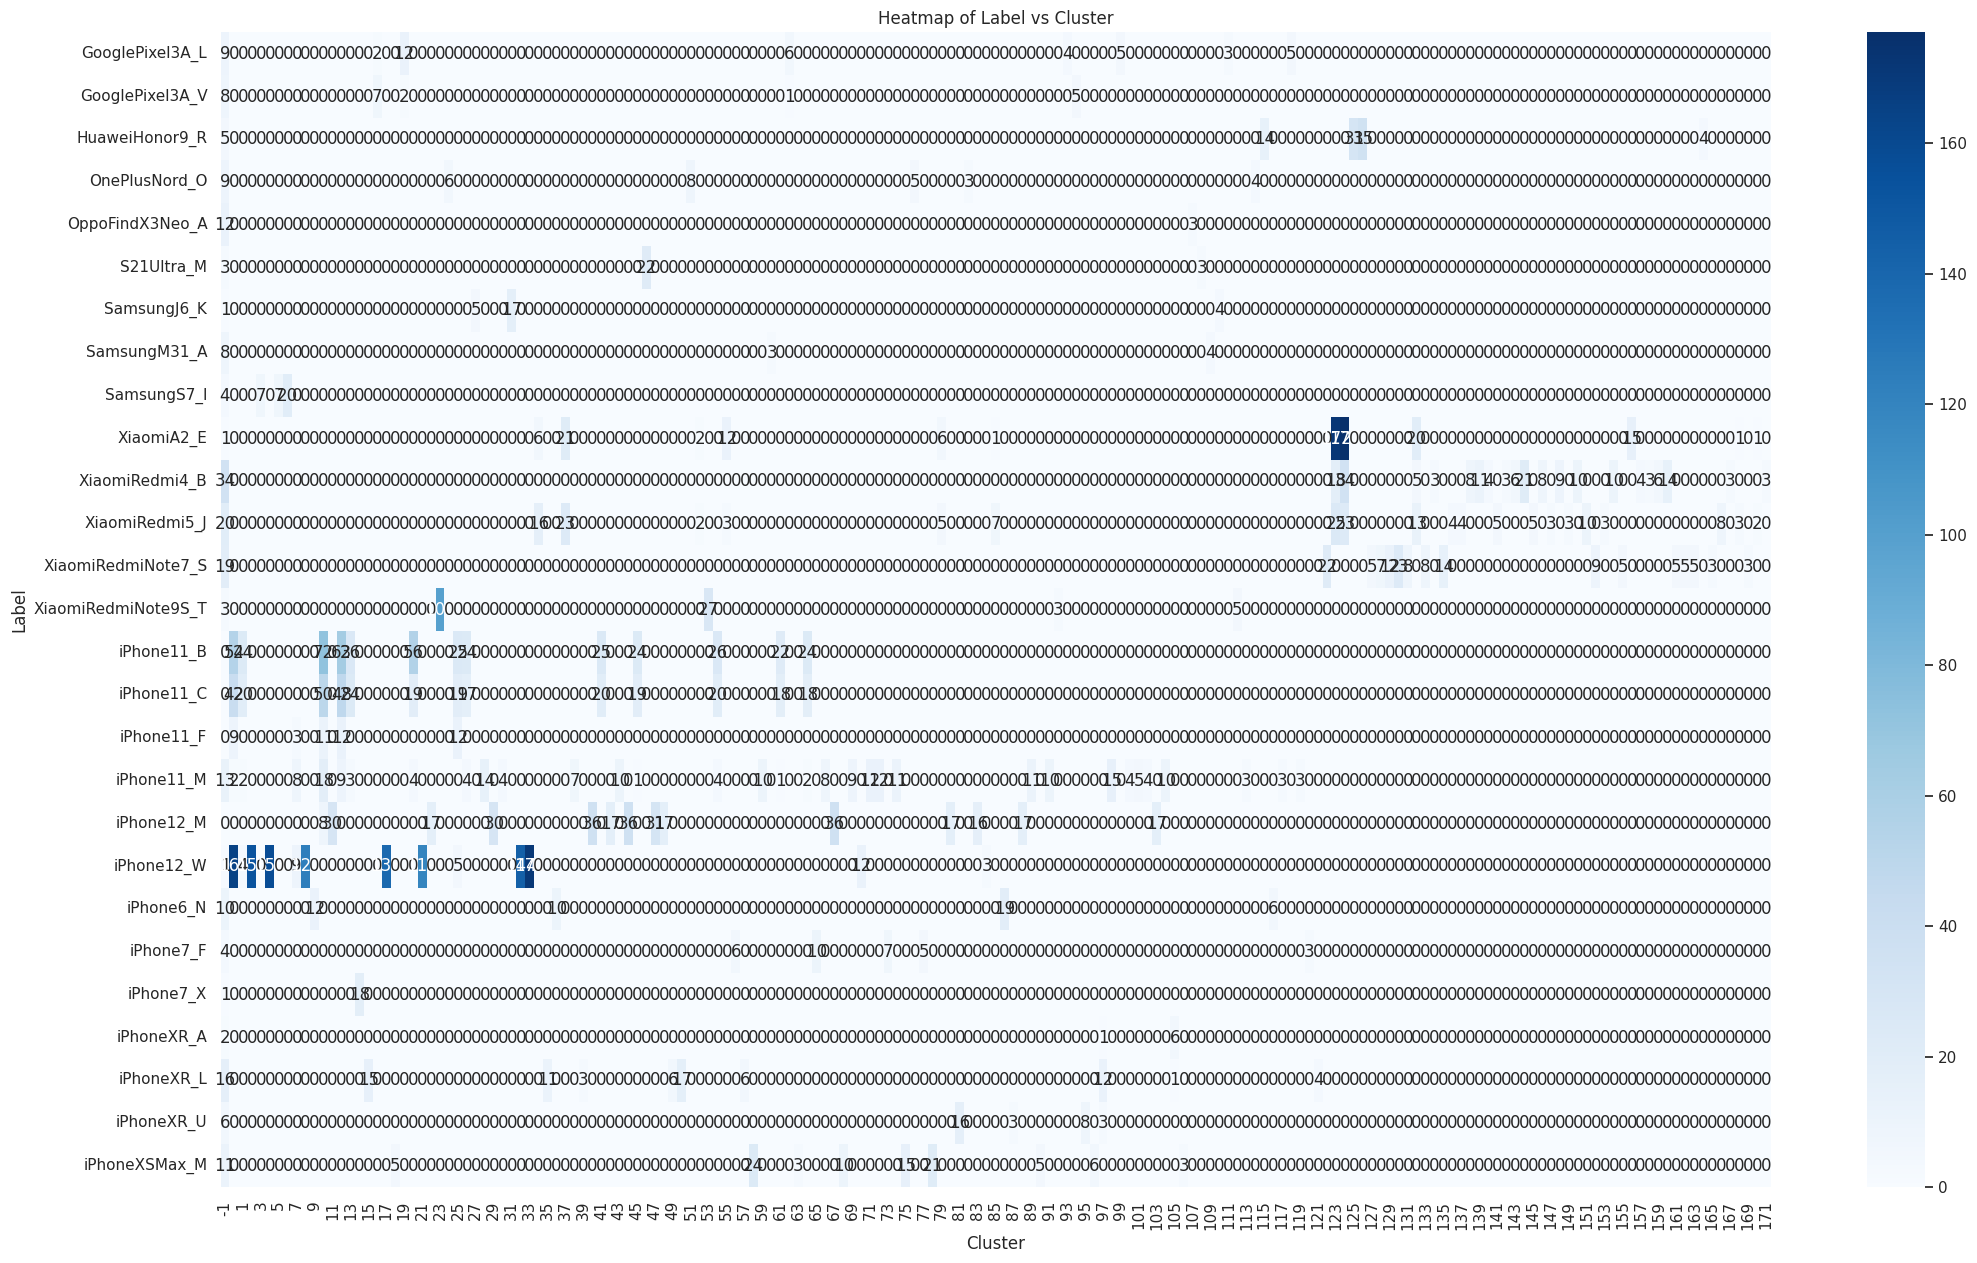

In [27]:
plotHelper.plot_heatmap(burst_df, "Label", "Cluster")

## Clustering Metrics

In [28]:
from sklearn.metrics import homogeneity_completeness_v_measure

In [29]:
# Compute homogeneity, completeness, and V-measure
h, c, v = homogeneity_completeness_v_measure(burst_df["Label"], burst_df["Cluster"])

In [30]:
print("Homogeneity: \t", h)
print("Completeness: \t", c)
print("V-measure: \t", v)

Homogeneity: 	 0.8151996996933607
Completeness: 	 0.49394666243125773
V-measure: 	 0.6151568419363169
